In [1]:
import tensorflow as tf
import numpy as np

2023-02-20 05:37:31.063639: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-20 05:37:31.199199: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-20 05:37:31.199213: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-20 05:37:31.851360: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7:

In [2]:
Xtrain = np.linspace(-10, 10, num=1024, dtype=np.float32)
ytrain = 0.8 * (Xtrain - 3) **2 - 3 + 2 * np.random.randn(*Xtrain.shape)
ytrain = ytrain.astype(np.float32)

# Construct Tensorflow Dataset

The `from_tensor_slices` function creates datasets whose elements are the slices of input Tensors along 1st dimension.

e.g.

```
dataset = tf.data.Dataset.from_tensor_slices(([1, 2], [3, 4], [5, 6]))
list(dataset.as_numpy_iterator())
[(1,3,5), (2,4,6)]
```

In [3]:

BATCH_SIZE = 16

train_data = tf.data.Dataset.from_tensor_slices((Xtrain, ytrain)).shuffle(BATCH_SIZE).batch(BATCH_SIZE)

x, y = train_data.as_numpy_iterator().next()

display(x, y)
tf.reduce_mean(0.8 * (x-3)**2 -3 - y)

2023-02-20 05:37:32.597659: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-20 05:37:32.598090: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-20 05:37:32.598195: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-20 05:37:32.598289: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; 

array([-9.941349 , -9.745846 , -9.863148 , -9.784946 , -9.824047 ,
       -9.6676445, -9.804497 , -9.98045  , -9.648094 , -9.726295 ,
       -9.550343 , -9.511242 , -9.47214  , -9.960899 , -9.589443 ,
       -9.628544 ], dtype=float32)

array([133.4943  , 125.302   , 130.398   , 128.91954 , 130.23195 ,
       125.90683 , 126.5731  , 132.17601 , 124.939835, 126.176346,
       119.33746 , 122.512405, 119.22106 , 130.97209 , 123.3424  ,
       123.34269 ], dtype=float32)

<tf.Tensor: shape=(), dtype=float32, numpy=0.25771046>

# Create Model with basic Tensorflow API

In [12]:
class Model:

    def __init__(self):
        self.A = tf.Variable(np.random.rand(1), dtype=tf.float32)
        self.B = tf.Variable(np.random.rand(1), dtype=tf.float32)
        self.C = tf.Variable(np.random.rand(1), dtype=tf.float32)


    @property
    def trainable_params(self):
        return (self.A, self.B, self.C)
    
    @tf.function
    def call(self, X):
        return self.A * X ** 2 + self.B * X + self.C
    
    def fit(self, train_data, epochs=100, learning_rate=1e-4):
        optimizer = tf.optimizers.SGD(learning_rate=learning_rate)        
        
        history = []
        
        for i in range(epochs):
            total_loss = 0.0
            
            for j, data in enumerate(train_data):
                X, y = data
                
                with tf.GradientTape() as tape:
                    predict = self.call(X)

                    # find the MSE of the loss
                    loss = tf.reduce_mean((y - predict) ** 2)
                    total_loss += loss

                    grads = tape.gradient(loss, self.trainable_params)
                    optimizer.apply_gradients(zip(grads, self.trainable_params))
                    
            avg_loss = total_loss / j
            print(f'epoch {i+1} step {j+1} training loss: {avg_loss}')
            
            history.append(avg_loss)
            
        return history

In [13]:
m = Model()

history = m.fit(train_data, epochs=30)


epoch 1 step 64 training loss: 289.1552429199219
epoch 2 step 64 training loss: 442.93927001953125
epoch 3 step 64 training loss: 337.31695556640625
epoch 4 step 64 training loss: 278.6481628417969
epoch 5 step 64 training loss: 224.85084533691406
epoch 6 step 64 training loss: 173.9883575439453
epoch 7 step 64 training loss: 134.3558807373047
epoch 8 step 64 training loss: 114.61261749267578
epoch 9 step 64 training loss: 87.57335662841797
epoch 10 step 64 training loss: 71.45248413085938
epoch 11 step 64 training loss: 54.50453186035156
epoch 12 step 64 training loss: 42.68027877807617
epoch 13 step 64 training loss: 40.44407272338867
epoch 14 step 64 training loss: 30.137042999267578
epoch 15 step 64 training loss: 27.131166458129883
epoch 16 step 64 training loss: 20.348501205444336
epoch 17 step 64 training loss: 17.294509887695312
epoch 18 step 64 training loss: 14.132933616638184
epoch 19 step 64 training loss: 13.614270210266113
epoch 20 step 64 training loss: 11.98482513427734

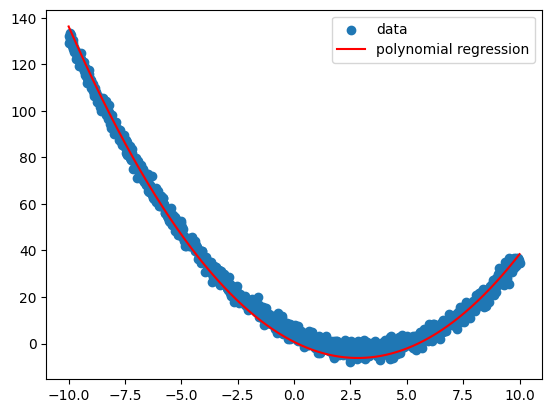

In [14]:
import matplotlib.pyplot as plt

y_pred = m.call(Xtrain)

plt.scatter(Xtrain, ytrain, label='data')
plt.plot(Xtrain, y_pred, color='r', label='polynomial regression')
plt.legend()
plt.show()

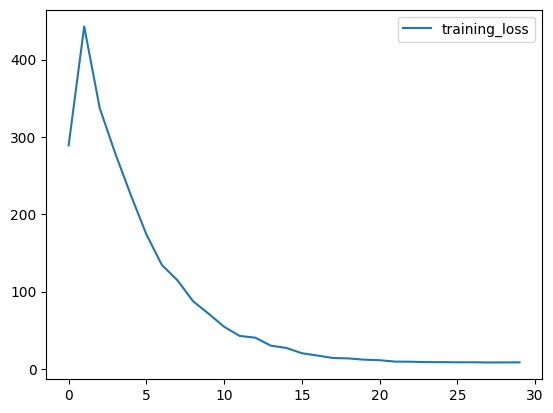

In [15]:
plt.plot(history, label='training_loss')
plt.legend()
plt.show()

# Create Model with Keras API

In [109]:
from tensorflow import keras

def build_keras_model():
    model = keras.models.Sequential([
        keras.layers.Input(shape=(1,)),
        keras.layers.Dense(3, activation='linear'),
        keras.layers.Dense(3, activation='linear'),                        
        keras.layers.Dense(1, activation='linear'),
    ])
    
    model.compile(
        loss=keras.losses.MSE, 
        optimizer=keras.optimizers.Adam(learning_rate=5e-4))
    
    return model

model = build_keras_model()

model.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_73 (Dense)            (None, 3)                 6         
                                                                 
 dense_74 (Dense)            (None, 3)                 12        
                                                                 
 dense_75 (Dense)            (None, 1)                 4         
                                                                 
Total params: 22
Trainable params: 22
Non-trainable params: 0
_________________________________________________________________


In [110]:
history = model.fit(train_data, epochs=20, batch_size=32)

Epoch 1/20
64/64 [==============================] - 0s 930us/step - loss: 2094.2073
Epoch 2/20
64/64 [==============================] - 0s 912us/step - loss: 2069.7046
Epoch 3/20
64/64 [==============================] - 0s 933us/step - loss: 2042.8022
Epoch 4/20
64/64 [==============================] - 0s 977us/step - loss: 2013.1379
Epoch 5/20
64/64 [==============================] - 0s 928us/step - loss: 1981.6311
Epoch 6/20
64/64 [==============================] - 0s 954us/step - loss: 1948.6710
Epoch 7/20
64/64 [==============================] - 0s 937us/step - loss: 1914.4714
Epoch 8/20
64/64 [==============================] - 0s 954us/step - loss: 1879.1476
Epoch 9/20
64/64 [==============================] - 0s 926us/step - loss: 1842.8763
Epoch 10/20
64/64 [==============================] - 0s 904us/step - loss: 1805.7812
Epoch 11/20
64/64 [==============================] - 0s 952us/step - loss: 1768.0023
Epoch 12/20
64/64 [==============================] - 0s 921us/step - loss:

32/32 [==============================] - 0s 824us/step


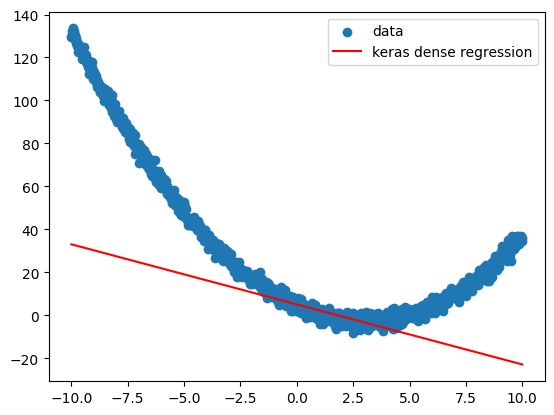

In [111]:
y_pred = model.predict(Xtrain)

plt.scatter(Xtrain, ytrain, label='data')
plt.plot(Xtrain, y_pred, color='r', label='keras dense regression')
plt.legend()
plt.show()

Notice that the Dense neural network model doesn't work very well with polynomial data.

To fix this, we can use keras `Lambda` layers and Concatenation to construct higher degree polynomial models.

In [169]:
def build_poly_model():
    model = keras.Model()
    input_layer = keras.layers.Input(shape=(1,))
    degree2 = keras.layers.Lambda(lambda x: x ** 2)(input_layer)
    
    concate = keras.layers.Concatenate()([input_layer, degree2])
    
    out = keras.layers.Dense(1, activation='linear')(concate)

    model = keras.Model(inputs=input_layer, outputs=out)
    
    model.compile(
        loss=keras.losses.MSE, 
        optimizer=keras.optimizers.Adam(learning_rate=5e-3))
    
    return model

model = build_poly_model()

model.summary()

Model: "model_26"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_51 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 lambda_17 (Lambda)             (None, 1)            0           ['input_51[0][0]']               
                                                                                                  
 concatenate_17 (Concatenate)   (None, 2)            0           ['input_51[0][0]',               
                                                                  'lambda_17[0][0]']              
                                                                                                  
 dense_97 (Dense)               (None, 1)            3           ['concatenate_17[0][0]']  

In [170]:
history = model.fit(train_data, epochs=50, batch_size=32)

Epoch 1/50
64/64 [==============================] - 0s 867us/step - loss: 982.1477
Epoch 2/50
64/64 [==============================] - 0s 856us/step - loss: 849.2776
Epoch 3/50
64/64 [==============================] - 0s 893us/step - loss: 740.6998
Epoch 4/50
64/64 [==============================] - 0s 889us/step - loss: 648.1938
Epoch 5/50
64/64 [==============================] - 0s 862us/step - loss: 571.2260
Epoch 6/50
64/64 [==============================] - 0s 879us/step - loss: 506.3038
Epoch 7/50
64/64 [==============================] - 0s 871us/step - loss: 450.0786
Epoch 8/50
64/64 [==============================] - 0s 871us/step - loss: 400.6168
Epoch 9/50
64/64 [==============================] - 0s 894us/step - loss: 356.2602
Epoch 10/50
64/64 [==============================] - 0s 899us/step - loss: 316.4387
Epoch 11/50
64/64 [==============================] - 0s 873us/step - loss: 280.4376
Epoch 12/50
64/64 [==============================] - 0s 892us/step - loss: 247.9377
E

32/32 [==============================] - 0s 765us/step


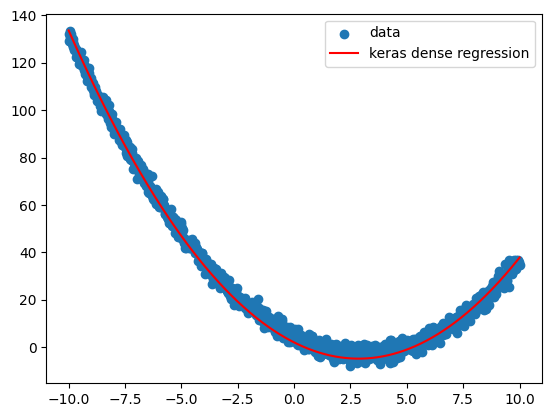

In [171]:
y_pred = model.predict(Xtrain)

plt.scatter(Xtrain, ytrain, label='data')
plt.plot(Xtrain, y_pred, color='r', label='keras dense regression')
plt.legend()
plt.show()

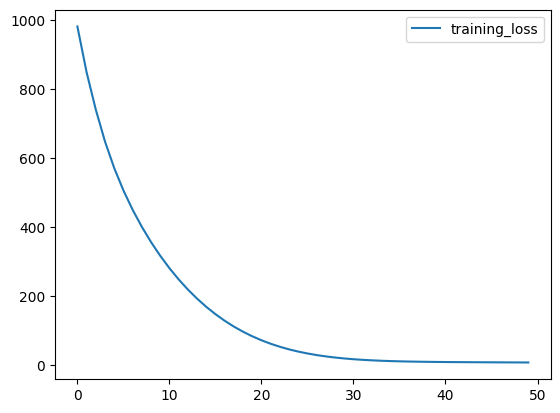

In [172]:
plt.plot(history.history['loss'], label='training_loss')
plt.legend()
plt.show()